In [34]:
import numpy as np

import jax
import jax.numpy as jnp
import flax.linen as nn
import optax
from flax.training import train_state

import matplotlib.pyplot as plt


data_dir = "./data"
device = jax.devices('cpu')[0]

print(f"Data resides in        : {data_dir}")
print(f"Training model on      : {str(device)}")

Data resides in        : ./data
Training model on      : TFRT_CPU_0


In [22]:
import os
import gzip
import requests
from tqdm import tqdm


def download_mnist_if_needed(root="./data", train_only=False):
    mnist_base_url = "https://storage.googleapis.com/cvdf-datasets/mnist/"
    mnist_file_name_dict = {
        "train_images": "train-images-idx3-ubyte.gz",
        "train_labels": "train-labels-idx1-ubyte.gz",
    }
    mnist_test_file_name_dict = {
        "test_images": "t10k-images-idx3-ubyte.gz",
        "test_labels": "t10k-labels-idx1-ubyte.gz",
    }
    if not train_only:
        mnist_file_name_dict.update(mnist_test_file_name_dict)

    mnist_raw_dir = os.path.join(root, "MNIST", "raw")
    os.makedirs(mnist_raw_dir, exist_ok=True)

    for file_key, file_name in mnist_file_name_dict.items():
        path = os.path.join(mnist_raw_dir, file_name)

        if os.path.exists(path):
            continue

        response = requests.get(mnist_base_url + file_name, stream=True)

        download_desc = f"Downloading {file_name}"
        tqdm_bar = tqdm(desc=download_desc, total=int(response.headers.get('content-length', 0)), unit='B', unit_scale=True)
        with open(path, 'wb') as f, tqdm_bar:
            for chunk in response.iter_content(chunk_size=1024):
                f.write(chunk)
                tqdm_bar.update(len(chunk))

    file_path_dict = {file_key: os.path.join(mnist_raw_dir, file_name) for file_key, file_name in mnist_file_name_dict.items()}

    return file_path_dict


def load_images(path):
    with gzip.open(path, 'rb') as f:
        f.read(16)
        data = np.frombuffer(f.read(), dtype=np.uint8)
    return data.reshape(-1, 28, 28)


def load_labels(path):
    with gzip.open(path, 'rb') as f:
        f.read(8)
        data = np.frombuffer(f.read(), dtype=np.uint8)
        return data

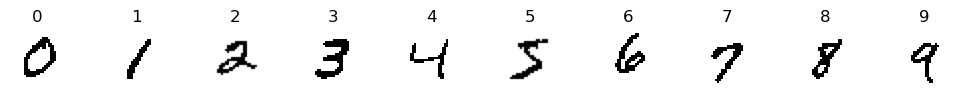

In [32]:
def print_samples(samples, elements_per_row=10, fig_width=10, cmap="binary"):
    num_digits = len(samples)
    num_rows = (num_digits + elements_per_row - 1) // elements_per_row

    plt.figure(figsize=(fig_width, fig_width / elements_per_row * num_rows))
    for idx, (label, image) in enumerate(samples):
        plt.subplot(num_rows, elements_per_row, idx + 1)
        plt.imshow(image.squeeze(), cmap=cmap)
        plt.title(label, fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


def preprocess(x):
    x = x.astype(np.float32) / 255.0    # normalize to [0, 1]
    x = x > 0.5                         # binarize
    x = jnp.array(x, dtype=jnp.float32) # use jax numpy array of dtype float32, because RBM has float32 params
    return x


data_paths = download_mnist_if_needed(root=data_dir, train_only=True)
x_train_raw = load_images(data_paths['train_images'])
y_train = load_labels(data_paths['train_labels'])

x_train = preprocess(x_train_raw)
# will result in: x_train dtype: float32, shape: (60000, 28, 28)

sample_list = [(label, x_train[np.where(y_train == label)[0][0]]) for label in range(10)]
print_samples(sample_list)

In [ ]:
class RBM(nn.Module):
    n_visible: int
    n_hidden: int

    def setup(self):
        self.W = self.param("W", nn.initializers.normal(0.01), (self.n_visible, self.n_hidden))
        self.b = self.param("b", nn.initializers.zeros, (self.n_visible,))
        self.c = self.param("c", nn.initializers.zeros, (self.n_hidden,))

    def _sample_hidden(self, v, T=1.0):
        key = self.make_rng("sample")
        logits = (v @ self.W + self.c) / T
        h_probs = jax.nn.sigmoid(logits)
        h_sample = jax.random.bernoulli(key, h_probs)
        return h_sample, h_probs

    def _sample_visible(self, h, T=1.0):
        key = self.make_rng("sample")
        logits = (h @ self.W.T + self.b) / T
        v_probs = jax.nn.sigmoid(logits)
        v_sample = jax.random.bernoulli(key, v_probs)
        return v_sample, v_probs

    def sample_gibbs(self, v0_sample, k=1, T=1.0):
        v = v0_sample
        for _ in range(k):
            h, _ = self._sample_hidden(v, T)
            v, _ = self._sample_visible(h, T)
        return v

    def free_energy(self, v):
        visible_term = jnp.dot(v, self.b)
        hidden_term = jnp.sum(jax.nn.softplus(v @ self.W + self.c), axis=1)
        return -visible_term - hidden_term

    def generate(self, params, n_samples=16, T_schedule=None, seed=0):
        key = jax.random.PRNGKey(seed)
        rbm = self.bind({"params": params}, rngs={"sample": key})
        v = jax.random.bernoulli(key, shape=(n_samples, self.n_visible)).astype(jnp.float32)

        for i, T in enumerate(T_schedule):
            key = jax.random.fold_in(key, i)
            rbm = rbm.replace_rngs({"sample": key})
            v = rbm.sample_gibbs(v, k=1, T=T)

        return v

    def __call__(self, v):
        return v # flax linen requires a __call__ method

In [41]:
import jax
import jax.numpy as jnp
import optax
from flax.training import train_state
from functools import partial

def create_train_state(rbm, rng, n_visible, lr, weight_decay, lr_decay):
    params = rbm.init(
        {"params": rng, "sample": rng},
        jnp.zeros((1, n_visible), jnp.float32),
    )["params"]

    scheduler = optax.exponential_decay(
        init_value=lr,
        transition_steps=1,
        decay_rate=lr_decay,
        staircase=False,
    )

    tx = optax.adamw(
        learning_rate=scheduler,
        weight_decay=weight_decay,
    )

    return train_state.TrainState.create(apply_fn=rbm.apply, params=params, tx=tx)

def create_train_step(rbm):
    @partial(jax.jit, static_argnums=(2,))
    def train_step(state, v_data, k, rng):
        def loss_fn(params):
            fe_data = rbm.apply({"params": params, "sample": rng}, v_data, method=RBM.free_energy)

            def gibbs_chain(v0, step):
                key = jax.random.fold_in(rng, step)
                return rbm.apply({"params": params, "sample": key}, v0, method=RBM.sample_gibbs, k=1)

            v_model = jax.lax.fori_loop(0, k, gibbs_chain, v_data)
            fe_model = rbm.apply({"params": params, "sample": rng}, v_model, method=RBM.free_energy)

            loss = jnp.mean(fe_data) - jnp.mean(fe_model)
            return loss, (v_model,)

        grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
        (loss, (v_model,)), grads = grad_fn(state.params)
        new_state = state.apply_gradients(grads=grads)
        return new_state, v_model, loss
    return train_step

def train_rbm(rbm, x_train, batch_size=128, num_epochs=10, k=1,
              lr=1e-3, weight_decay=1e-5, lr_decay=0.95, pcd_reset=5, seed=42):
    rng = jax.random.PRNGKey(seed)
    n_samples, *rest = x_train.shape
    if len(rest) == 2:
        x_train = x_train.reshape(n_samples, -1)

    n_visible = x_train.shape[1]
    state = create_train_state(rbm, rng, n_visible, lr, weight_decay, lr_decay)
    train_step = create_train_step(rbm)

    def get_batches():
        indices = jax.random.permutation(rng, n_samples)
        for start in range(0, n_samples, batch_size):
            yield x_train[indices[start:start+batch_size]]

    p_rng = jax.random.split(rng, 1)[0]
    fantasy_particles = jax.random.bernoulli(p_rng, shape=(batch_size, n_visible)).astype(jnp.float32)

    metrics = {}
    global_step = 0

    for epoch in range(num_epochs):
        batch_losses = []
        for batch_idx, batch_data in enumerate(get_batches()):
            if batch_data.shape[0] < batch_size:
                continue

            if (batch_idx % pcd_reset) == 0:
                p_rng = jax.random.fold_in(rng, epoch * 1000 + batch_idx)
                fantasy_particles = jax.random.bernoulli(p_rng, shape=(batch_size, n_visible)).astype(jnp.float32)

            step_rng, rng = jax.random.split(rng)
            state, v_model, loss = train_step(state, batch_data, k, step_rng)
            fantasy_particles = v_model
            batch_losses.append(loss)
            global_step += 1

        # Manual LR schedule update (optional)
        new_opt_state = state.tx.update_fn(optax.EmptyState(), state.tx_state, state.params)
        state = state.replace(tx_state=new_opt_state)

        epoch_loss = jnp.mean(jnp.array(batch_losses))
        metrics[epoch] = {"free_energy_loss": float(epoch_loss)}
        print(f"Epoch [{epoch+1}/{num_epochs}] - Free Energy Loss: {epoch_loss:.4f}")

    return state, metrics


In [42]:
rng = jax.random.PRNGKey(0)
rbm = RBM(n_visible=784, n_hidden=256)

# Train the RBM
trained_state, metrics = train_rbm(
    rbm,
    x_train,
    batch_size=128,
    num_epochs=40,
    k=1,
    lr=1e-3,
    weight_decay=1e-5,
    lr_decay=0.95,
    pcd_reset=75,
    seed=42
)

ApplyScopeInvalidVariablesTypeError: The first argument passed to an apply function should be a dictionary of collections. Each collection should be a dictionary with string keys. (https://flax.readthedocs.io/en/latest/api_reference/flax.errors.html#flax.errors.ApplyScopeInvalidVariablesTypeError)

In [20]:
import jax
import jax.numpy as jnp
import optax
from flax.training import train_state

def create_train_state(rbm, learning_rate, weight_decay=1e-5, lr_decay=1.0):
    if lr_decay < 1.0:
        schedule_fn = optax.exponential_decay(
            init_value=learning_rate,
            transition_steps=1,
            decay_rate=lr_decay,
            staircase=False
        )
    else:
        schedule_fn = learning_rate

    tx = optax.chain(
        optax.add_decayed_weights(weight_decay),
        optax.adam(schedule_fn),
    )

    rng = jax.random.PRNGKey(0)
    dummy_input = jnp.ones((1, rbm.n_visible), dtype=jnp.float32)
    params = rbm.init({"params": rng, "sample": rng}, dummy_input)["params"]
    return train_state.TrainState.create(apply_fn=rbm.apply, params=params, tx=tx)

@jax.jit
def compute_loss(params, apply_fn, v_data, v_model):
    fe_data = apply_fn({"params": params}, v_data, method=RBM.free_energy)
    fe_model = apply_fn({"params": params}, v_model, method=RBM.free_energy)
    return fe_data.mean() - fe_model.mean()

def train_step(state, v_data, v_persistent, rng, k):
    rbm_bound = RBM(state.params["W"].shape[0], state.params["W"].shape[1]).bind(
        {"params": state.params},
        rngs={"sample": rng}
    )
    v_model = rbm_bound.sample_gibbs(v_persistent, k=k)

    def loss_fn(params):
        return compute_loss(params, state.apply_fn, v_data, v_model), v_model

    (loss_value, v_model_new), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)
    return state, v_model_new, loss_value

# JIT with static k
train_step = jax.jit(train_step, static_argnames=["k"])

def train_rbm(rbm, train_loader, num_epochs, k, init_lr=1e-3, weight_decay=1e-5,
              lr_decay=0.95, pcd_reset=75, seed=0):
    state = create_train_state(rbm, init_lr, weight_decay, lr_decay)
    rng = jax.random.PRNGKey(seed)
    batch_size = train_loader.batch_size
    v_persistent = jax.random.bernoulli(rng, shape=(batch_size, rbm.n_visible)).astype(jnp.float32)

    metrics = {}
    for epoch in range(num_epochs):
        total_loss = 0.0
        batch_count = 0

        for batch_idx, (images, _) in enumerate(train_loader):
            images = images.reshape(-1, rbm.n_visible).astype(jnp.float32)

            if batch_idx % pcd_reset == 0:
                rng, key_reset = jax.random.split(rng)
                v_persistent = jax.random.bernoulli(key_reset, shape=(batch_size, rbm.n_visible)).astype(jnp.float32)

            rng, key_step = jax.random.split(rng)
            state, v_persistent, loss_value = train_step(state, images, v_persistent, key_step, k)

            total_loss += loss_value.item()
            batch_count += 1

        avg_loss = total_loss / batch_count
        metrics[epoch] = {"free_energy_loss": float(avg_loss)}
        print(f"Epoch [{epoch+1}/{num_epochs}] - Free Energy Loss: {avg_loss:.4f}")

    return state, metrics

In [21]:
batch_size      = 128
visible_units   = 28 * 28
hidden_units    = 256
k               = 1
lr              = 1e-3
num_epochs      = 40
pcd_reset       = 75
weight_decay    = 1e-5
lr_decay        = 0.95

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
rbm = RBM(visible_units, hidden_units)
state, metrics = train_rbm(rbm, train_loader, num_epochs, k, lr, weight_decay, lr_decay, pcd_reset)

TypeError: Cannot interpret value of type <class 'method'> as an abstract array; it does not have a dtype attribute

In [21]:
from torch.utils.data import DataLoader
import optax

# ⚙️ Hyperparameters


# 🧱 Dataloader (from PyTorch for convenience)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# 📉 Learning rate scheduler (one step per epoch)
schedule = optax.exponential_decay(
    init_value=lr,
    transition_steps=len(train_loader),
    decay_rate=lr_decay,
    staircase=True
)

# ⚙️ Optimizer
optimizer = optax.adamw(learning_rate=schedule, weight_decay=weight_decay)

# 🧠 RBM instance
rbm = RBM(n_visible=visible_units, n_hidden=hidden_units)

# 🚂 Train!
state, metrics = train_rbm(
    rbm=rbm,
    train_loader=train_loader,
    num_epochs=num_epochs,
    k=k,
    optimizer=optimizer,
    scheduler=schedule,
    pcd_reset=pcd_reset
)

TypeError: cannot unpack non-iterable NoneType object

Text(0, 0.5, 'Free Energy Loss')

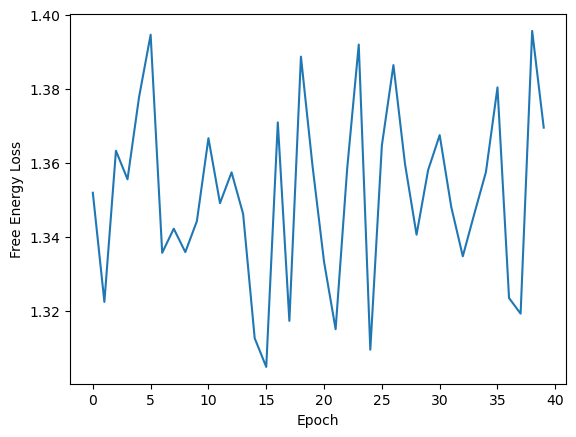

In [37]:
plt.plot([abs(metrics[epoch]['free_energy_loss']) for epoch in metrics])
plt.xlabel("Epoch")
plt.ylabel("Free Energy Loss")

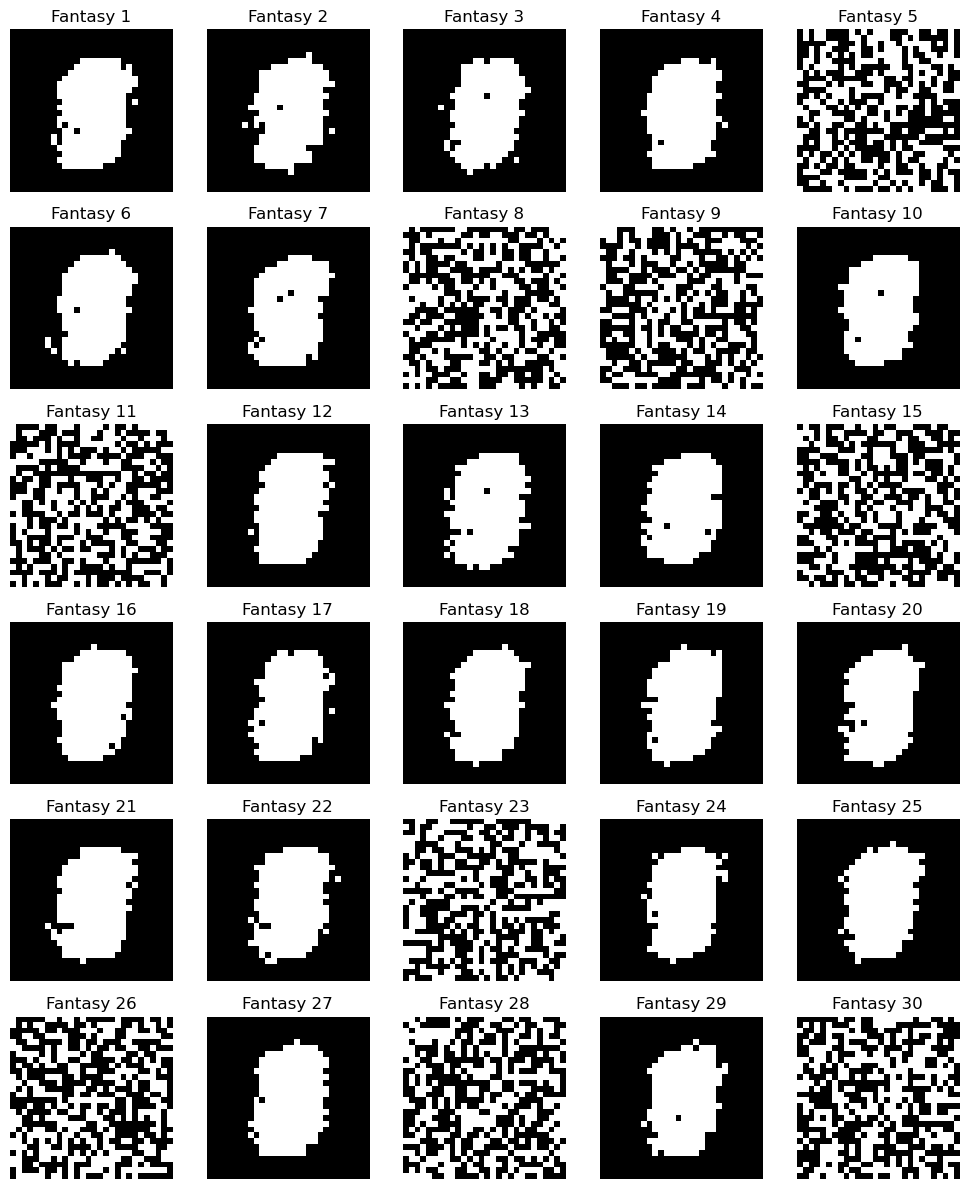

In [38]:
class CosineAnnealer:
    def __init__(self, T_high, T_low, n_steps):
        steps = jnp.arange(n_steps, dtype=jnp.float32)
        cos = 0.5 * (1 + jnp.cos(jnp.pi * steps / (n_steps - 1)))
        self.schedule = T_low + (T_high - T_low) * cos

    def __getitem__(self, idx):
        return self.schedule[idx]

    def __len__(self):
        return len(self.schedule)

    def get_schedule(self):
        return self.schedule


annealer = CosineAnnealer(4.0, 0.4, 1000)
T_schedule = annealer.get_schedule()

samples = rbm.generate(params=state.params, n_samples=30, T_schedule=T_schedule)
samples = samples.reshape(-1, 1, 28, 28)

labeled_samples = [(f"Fantasy {i + 1}", np.array(samples[i])) for i in range(len(samples))]
print_samples(labeled_samples, elements_per_row=5, fig_width=10, cmap="gray")